In [1]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import json
from PIL import Image, ImageDraw, ImageFont
import re

def load_H5_bodypart(tracking_path,video_type, tracking_point):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'task' in file:
                back_file = pd.read_hdf(tracking_path + file)     
                
    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]
    body_part = back_file[scorer][tracking_point]
    
    parts=[]
    for item in list(back_file[scorer]):
        parts+=[item[0]]
    print(np.unique(parts))
    
    # clean and interpolate frames with less than 98% confidence
    clean_and_interpolate(body_part,0.98)
    
    return(body_part)
  
def load_H5_ports(tracking_path,video_type):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'port' in file:
                back_ports_file = pd.read_hdf(tracking_path + file)

    ## same for the ports:
    scorer = back_ports_file.columns.tolist()[0][0]
        
    if video_type == 'back':
        port1 =back_ports_file[scorer]['port2']
        port2 =back_ports_file[scorer]['port1']
        port3 =back_ports_file[scorer]['port6']
        port4 =back_ports_file[scorer]['port3']
        port5 =back_ports_file[scorer]['port7']
    else:
        port1 =back_ports_file[scorer]['Port2']
        port2 =back_ports_file[scorer]['Port1']
        port3 =back_ports_file[scorer]['Port6']
        port4 =back_ports_file[scorer]['Port3']
        port5 =back_ports_file[scorer]['Port7']

    clean_and_interpolate(port1,0.98)
    clean_and_interpolate(port2,0.98)
    clean_and_interpolate(port3,0.98)
    clean_and_interpolate(port4,0.98)
    clean_and_interpolate(port5,0.98)
    
    return(port1,port2,port3,port4,port5)


def list_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

def clean_and_interpolate(head_centre,threshold):
    bad_confidence_inds = np.where(head_centre.likelihood.values<threshold)[0]
    newx = head_centre.x.values
    newx[bad_confidence_inds] = 0
    newy = head_centre.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    head_centre['interped_x'] = interped_x
    head_centre['interped_y'] = interped_y
    
def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                #print('interp_start_index: ', interp_start_index)
                #print('interp_start_value: ', value_before)
                #print('')

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                    #print('interp_end_index: ', interp_end_index)
                    #print('interp_end_value: ', value_after)
                    #print('')

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                    #print('interp_diff_index is:', interp_diff_index)

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        #print('interp_index is:', interp_index)
                        #print('new_value should be:', new_values[x])
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
#     print('function exiting')
    return(coords_list)

def sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=None, th=0.2):
    ## this is number of neurons in total
    N_neurons= bkgd_log_proportions_array.shape[1]
    ## number of sequences from json file 
    n_sequences = config["num_sequence_types"]
    # the 18 neuron params for each neuron from the last iteration
    all_final_globals = neuron_response_df.iloc[-N_neurons:]
    # this cuts it down to just the first 6 params - i think this correspond sto the first param for each seq type? response probABILITY - ie the chance that a neuron spikes in a given latent seq 
    resp_prop = np.exp(all_final_globals.values[:, :n_sequences])#
    # this takes the next 6 params - which i think are the offset values
    offset = all_final_globals.values[-N_neurons:, n_sequences:2*n_sequences]
    ## finds the max response value - ie. which seq it fits to? 
    peak_response = np.amax(resp_prop, axis=1)
    # then threshold the reponse
    has_response = peak_response > np.quantile(peak_response, th)
    # I thin this is the sequence that the neuron has the max response for: ie. we are ordering them by max response 
    preferred_type = np.argmax(resp_prop, axis=1)
    if sequence_ordering is None:
        # order them by max reponse 
        ordered_preferred_type = preferred_type
    else:
        #order them differnetly 
        ordered_preferred_type = np.zeros(N_neurons)#
        # loop through each sequence
        for seq in range(n_sequences):
            # where does  max repsone = user defined seque
            seq_indices = np.where(preferred_type == sequence_ordering[seq])
            # change order to different seq
            ordered_preferred_type[seq_indices] = seq

    # reorder the offset params according to max respsone
    preferred_delay = offset[np.arange(N_neurons), preferred_type]
    Z = np.stack([has_response, ordered_preferred_type+1, preferred_delay], axis=1)
    indexes = np.lexsort((Z[:, 2], Z[:, 1], Z[:, 0]))
    return indexes,ordered_preferred_type

# Function to find corresponding number in another column
def find_corresponding(nums):
    return [df_dict[num] for num in nums]

def split_list(nums):
    sublists = []
    current_sublist = [nums[0]]
    current_element = nums[0]
    for i in range(1,len(nums)):
        if nums[i] == current_element:
            current_sublist.append(nums[i])
        else:
            sublists.append(current_sublist)
            current_sublist = [nums[i]]
            current_element = nums[i]
    sublists.append(current_sublist)
    return sublists

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.close()
    
def combine_list_strings(list_):
    string = ''
    for item in list_:
        string += item + '_'
    return string[0:-1]

def insert_row(idx, df, df_insert):
    return df.iloc[:idx, ].append(df_insert).append(df.iloc[idx:, ]).reset_index(drop = True)

def fix_missing_neurons(spikes_df):

    count = 0
    neuron_ids = spikes_df.neuron.values

    for index,_id_ in enumerate(neuron_ids[:-1]):
        if index == 0:
            if not _id_ == 1:
                new_row = pd.DataFrame({'neuron': [1.0], 'timestamp':[np.nan], 'sequence_type':[np.nan],  'seq_confidence': [np.nan], 'sequence_type_adjusted':[np.nan] })
                spikes_df= new_row.append(spikes_df)
                print(index)

                count +=1

        if not _id_ == neuron_ids[index+1]:
            if not _id_ + 1 == neuron_ids[index+1]:
                new_row = pd.DataFrame({'neuron': [_id_+1], 'timestamp':[np.nan], 'sequence_type':[np.nan],  'seq_confidence': [np.nan], 'sequence_type_adjusted':[np.nan] })
                insert_row(index,spikes_df,new_row)
                count +=1

    print(str(count) + ' neurons were missing - did not fire a spike' )

    return spikes_df.reset_index()


def return_inds_for_seq_groups(lst):
    groups = []
    peak_inds = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
                peak_ind = ind
        else:
            if item > lst[peak_ind]:
                peak_ind = ind
            if item == 0:
                end = ind
                if not start == 0:
                    groups.append((start-1, end))
                else:
                    groups.append((start, end))    
                peak_inds.append(peak_ind)
                new = True
    return groups,peak_inds

def find_missing_elements(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    missing_elements = set1 - set2
    return list(missing_elements)

# ### if two found rectangles overlap with a single motif then remove the smallest one
# def remove_overlapping_rectangles(overlap_proportion, implanted_index):
#     repeat_index = []
    
#     for i, index in enumerate(implanted_index):
#         if i > 0 and index == implanted_index[i - 1]:
#             repeat_index.append(i)
    
#     new_overlap_proportion = overlap_proportion.copy()
#     new_implanted_index = implanted_index.copy()
    
#     for index in repeat_index[::-1]:
#         a = overlap_proportion[index]
#         b = overlap_proportion[index - 1]
        
#         if a > b:
#             new_overlap_proportion.pop(index - 1)
#             new_implanted_index.pop(index - 1)
#         else:
#             new_overlap_proportion.pop(index)
#             new_implanted_index.pop(index)
    
#     return new_overlap_proportion, new_implanted_index


### if two found rectangles overlap with a single motif then remove the smallest one
def remove_overlapping_rectangles(overlap_proportion, implanted_index,actually_identified_seq_types):
    repeat_index = []
    
    for i, index in enumerate(implanted_index):
        if i > 0 and index == implanted_index[i - 1]:
            repeat_index.append(i)
    
    new_overlap_proportion = overlap_proportion.copy()
    new_implanted_index = implanted_index.copy()
    new_actually_identified_seq_types = actually_identified_seq_types.copy()
    
    for index in repeat_index[::-1]:
        a = overlap_proportion[index]
        b = overlap_proportion[index - 1]
        
        if a > b:
            new_overlap_proportion.pop(index - 1)
            new_implanted_index.pop(index - 1)
            new_actually_identified_seq_types.pop(index - 1)
        else:
            new_overlap_proportion.pop(index)
            new_implanted_index.pop(index)
            new_actually_identified_seq_types.pop(index)
    
    return new_overlap_proportion, new_implanted_index,new_actually_identified_seq_types

def area(a, b):  # returns None if rectangles don't intersect
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    
def has_numbers(input_string):
    return any(char.isdigit() for char in input_string)
def remove_numbers(input_string):
    return re.sub(r'\d', '', input_string)

C:\Users\EJThompson\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
os.listdir(r'Z:\projects\Emmett\synthetic_data_rerun\prepared_data')

['136_1_3',
 '148_2_2',
 '149_1_1',
 '178_1_6',
 '178_1_7',
 '178_2_1',
 '178_2_2',
 '178_2_3',
 '178_2_4',
 '255_1_2',
 '262_1_5',
 '269_1_2',
 '270_1_3']

none to run
running on 2 files that were missing
1/2 ---------------------------------------------------------
background_noise_spikes_100
loading
created folder :  Z:\projects\Emmett\synthetic_data_rerun\ppseq_output\\148_2_2\148_2_2_background_noise_spikes_100_run_1912023_0715/analysis_output
Z:\projects\Emmett\synthetic_data_rerun\ppseq_output\\148_2_2\148_2_2_background_noise_spikes_100_run_1912023_0715
LOADING PPSEQ DATA


      done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 363002/363002 [01:53<00:00, 3186.92it/s]


0 neurons were missing - did not fire a spike
1.0
2.0
3.0
4.0
5.0
6.0
0.5
mislablled:
0.4375
2/2 ---------------------------------------------------------
background_noise_spikes_40
loading
created folder :  Z:\projects\Emmett\synthetic_data_rerun\ppseq_output\\148_2_2\148_2_2_background_noise_spikes_40_run_1812023_2330/analysis_output
Z:\projects\Emmett\synthetic_data_rerun\ppseq_output\\148_2_2\148_2_2_background_noise_spikes_40_run_1812023_2330
LOADING PPSEQ DATA


      done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280600/280600 [01:20<00:00, 3473.30it/s]


0 neurons were missing - did not fire a spike
1.0
2.0
3.0
4.0
5.0
6.0
0.6435185185185185
mislablled:
0.3317307692307692
none to run
none to run
none to run
none to run
none to run
none to run
none to run
none to run
none to run
none to run
none to run


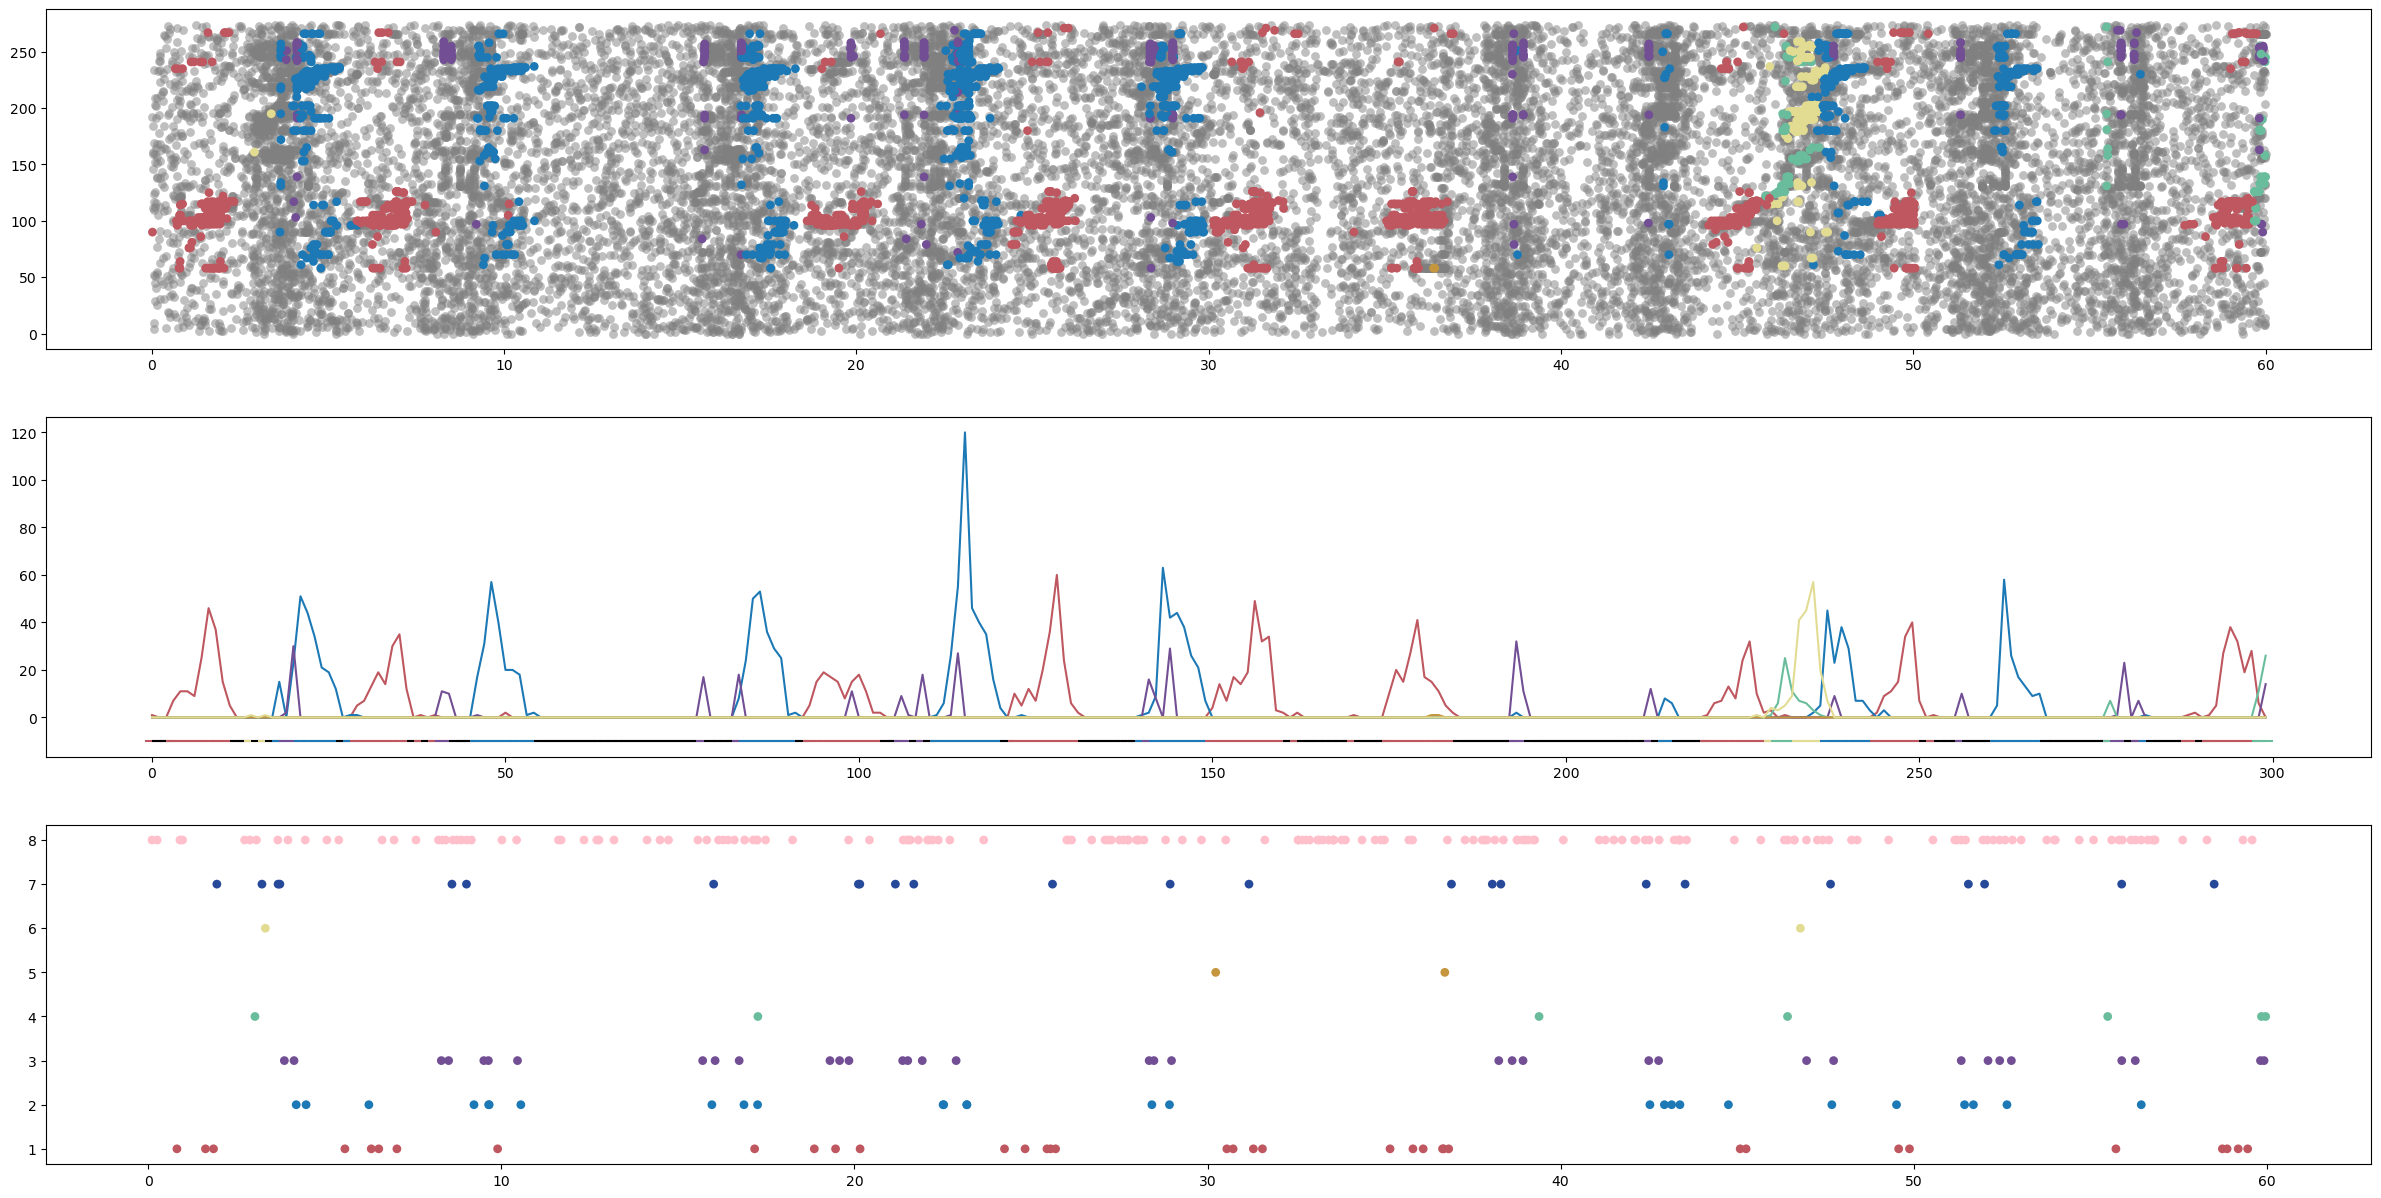

In [9]:
m_i_rs = ['136_1_3',
 '148_2_2',
 '149_1_1',
 '178_1_6',
 '178_1_7',
 '178_2_1',
 '178_2_2',
 '178_2_3',
 '178_2_4',
 '255_1_2',
 '262_1_5',
 '269_1_2',
 '270_1_3']
#         '148_2_2','149_1_1','178_1_6','178_1_7','178_2_1','178_2_3','178_2_4','269_1_2','270_1_3']

## PATHS
for mouse_session_recording in m_i_rs:
    
    ## check if files ahve already been run and if so skip these:
    synth_save_path = r"Z:\projects\Emmett\synthetic_data_rerun\synthetic_spikes\\"
    ppseq_out_path = "Z:\projects\Emmett\synthetic_data_rerun\ppseq_output\\" + mouse_session_recording + '\\'
    data_name = []
    for file_dir in os.listdir(ppseq_out_path):
        if mouse_session_recording in file_dir:
            string = ''
            for item in file_dir.split('_')[3:-3]:
                string += item + '_'
            data_name += [string[0:-1]]

    output_data_file_path = synth_save_path + "\\" + mouse_session_recording + '\\' + mouse_session_recording + "_proportions_found.csv"

    if os.path.isfile(output_data_file_path):
        output_df = pd.read_csv(output_data_file_path,index_col=0)
        output_df = output_df.reset_index(drop =True)
        new_data_name = []
        for d_n in data_name:
            if not d_n in output_df.type.values:
                new_data_name += [d_n]

        if len(new_data_name) == 0:
            print('none to run')
        else:
            print('running on ' + str(len(new_data_name)) + ' files that were missing')
        data_name = new_data_name

    else:
        print('creating new file')
        # create output df:
        output_df = pd.DataFrame(
            {'mouse_implant_recording' : [],
            'type' : [],
            'proportion_found' : [],
            'proportion_mislabeled': [],
            'seqs_implanted':[],
            'seqs_found_over_implanted':[]})
        output_df.to_csv(output_data_file_path)

    for run_index,session_name in enumerate(data_name):

        if not run_index == 19:
            print(str(run_index+1) + '/' + str(len(data_name)) +' ---------------------------------------------------------')
            print(session_name)

            PP_PATH = r"Z:\projects\Emmett\synthetic_data_rerun\ppseq_output\\" + mouse_session_recording + '\\'
            
            if has_numbers(session_name):
                if remove_numbers(session_name)[-1] == '.':
                    file_path_folder = remove_numbers(session_name)[0:-2] + '\\' + session_name
                else:
                    file_path_folder = remove_numbers(session_name)[0:-1] + '\\' + session_name
            else:
                file_path_folder = session_name
                
            implanted_data_path= r"Z:\projects\Emmett\synthetic_data_rerun\synthetic_spikes\\" + mouse_session_recording + "\\" + file_path_folder + '\\ppseq_events.pkl'

#             implanted_data_path= r"Z:\projects\Emmett\synthetic_data_rerun\synthetic_spikes\\" + mouse_session_recording + "\\" + file_path_folder
#             for item in os.listdir(implanted_data_path):
#                 current_file = combine_list_strings(item.split('_')[0:len(session_name.split('_'))])
#                 if session_name == current_file:
#                     print(item)
#                     implanted_data_path = implanted_data_path + item + '\\ppseq_events.pkl'


            ##  load in ground truth implanted data: 
            # standard insertion: 

            if not session_name == 'blank_test':
                print('loading')
                implanted_data = pd.read_pickle(implanted_data_path)

            DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"

            ## set ppseq file
            for file_ in os.listdir(PP_PATH):
                if session_name in file_:
                    if mouse_session_recording in file_:
                        file = file_

            ## set dat_path:
            for file_ in os.listdir(DAT_PATH):
                if mouse_session_recording.split('_')[0] in file_:
                    if mouse_session_recording.split('_')[1] == file_[-1]:
                        dat_path = os.path.join(DAT_PATH,file_)
            for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
                if recording.split('_')[0][-1] == mouse_session_recording.split('_')[-1]:
                    dat_path = os.path.join(dat_path,recording)

            # set tracking path
            for file_ in os.listdir(dat_path + r"\video\tracking\\"):
                if 'task' in file_:
                    tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
            # set video paths
            for file_ in os.listdir(dat_path + r"\video\videos\\"):
                if 'task' in file_:
                    cam_path = os.path.join(dat_path + r"\video\videos\\",file_) + '\\' 
                    for vid_file in os.listdir(cam_path):
                        if 'back' in vid_file and '.avi' in vid_file:
                            back_cam_avi_path = os.path.join(cam_path,vid_file)
                        if 'side' in vid_file and '.avi' in vid_file:
                            side_cam_avi_path = os.path.join(cam_path,vid_file)

            # set save paths:
            PP_save_path = PP_PATH + file + '/analysis_output'


            CHECK_FOLDER = os.path.isdir(PP_save_path)
            # If folder doesn't exist, then create it.
            if not CHECK_FOLDER:
                os.makedirs(PP_save_path)
                print("created folder : ", PP_save_path)



        # ------------------------------------------------------------------------------------------------------------------------------------------------------------------                    

            ## LOAD 
            print(PP_PATH + file)
            print("LOADING PPSEQ DATA")
            print('\n')
            #The assignment history frame (assigment_hist_frame.csv): Spikes by iterations, how each spike is assigned to a sequence ID (in latent_event_hist) or to background (-1)
            assignment_history_df = pd.read_csv(PP_PATH + file + r"\assigment_hist_frame.csv")

            # latent_event_hist.csv: history of latent events. All latent events across all iterations have a row
            latent_event_history_df = pd.read_csv(PP_PATH + file + r"\latent_event_hist.csv")

            # seq_type_log_proportions: log p of each type of sequence at each iteration
            seq_type_log_proportions_df = pd.read_csv(PP_PATH + file + r"\seq_type_log_proportions.csv")

            # neuron_responses.csv: iterations x neurons by 3(number of sequences). Each neuron has three parameters per sequence to describe how it is influenced by each sequence type. 
            # Each iteration these are resampled, therefore there are number of neurons by iterations by 3 by number of sequences of these numbers.
            neuron_response_df = pd.read_csv(PP_PATH + file + r"\neuron_response.csv")

            #log_p_hist.csv: the history of the log_p of the model
            log_p_hist_df = pd.read_csv(PP_PATH + file + r"\log_p_hist.csv")

            # unmasked_spikes_df = pd.read_csv(PP_PATH + file + r"\unmasked_spikes.csv")

            ## load in spikes 
            spikes_file = os.path.join(PP_PATH + file,'trainingData\\') + '_'.join(file.split('_')[0:-3]) + '.txt'

            neuron_ids, spike_times= [], []
            with open(spikes_file) as f:
                for (i, line) in enumerate(f.readlines()):
                    [neuron_id, spike_time] = line.split(' ', 1)
                    spike_time = eval(spike_time.split('\n')[0])
                    neuron_id = eval(neuron_id.split('\t')[0])
                    spike_times.append(spike_time)
                    neuron_ids.append(neuron_id)

            spikes_df = pd.DataFrame({'neuron':neuron_ids,'timestamp':spike_times}) 


            bkgd_log_proportions_array = pd.read_csv(PP_PATH + file + r"\bkgd_log_proportions_array.csv")

            # Opening JSON file
            f = open(PP_PATH + file + r'\config_file.json')

            # returns JSON object as 
            # a dictionary
            config = eval(json.load(f))

            print(f'      done')

            ## load in the timespan used for pppseq:
            string = ''
            for item in file.split('_')[0:-3]:
                string += item + '_'
            STRING = string[0:-1]
            input_params_path = os.path.join(PP_PATH + file,'trainingData\\') + ('params_' + STRING +'.json')
            # Opening JSON file
            f = open(input_params_path)
            # returns JSON object as a dictionary
            input_config = json.load(f)
            behav_time_interval_start = input_config['time_span'][0]



            time_spans = [[0,600]]
            behav_time_interval_start = time_spans[0]

            # ------------------------------------------------------------------------------------------------------------------------------------------------------------------    
            plt.close()
            #find max value

            # find 95% of growth value and when it crossed this
            max_ = max(log_p_hist_df.x1)
            min_ = min(log_p_hist_df.x1)
            growth = max_ - min_
            _prcntile =  max_ - (0.02 * growth)

            ## model log likley hood curve
            plt.plot(log_p_hist_df.x1)
            plt.axhline(y=_prcntile, color='r', linestyle='--')


            SaveFig('/log_l_curve.png',PP_save_path)

            # ------------------------------------------------------------------------------------------------------------------------------------------------------------------    

            ## macth seq id to seq type across itterations

            # Initialize an empty df to store the result
            seq_types_df = pd.DataFrame()

            # Iterate through the range
            # for iteration_ in tqdm(range(400, 500)):
            for iteration_ in tqdm(range(200,300)):

                # Extract the relevant column from the assignment history dataframe
                assignment_history_df_split = assignment_history_df[str(list(assignment_history_df)[iteration_])]

                # Get the index of the -1 split markers in the latent event history dataframe
                end_markers = latent_event_history_df.loc[latent_event_history_df['seq_type'] == -1.0].index
                # Extract the relevant portion of the latent event history dataframe
                latent_event_history_df_split =  latent_event_history_df[end_markers[iteration_-1]:end_markers[iteration_]]

                # Create a dictionary from the dataframe for faster lookups
                df_dict = latent_event_history_df_split.set_index('assignment_id')['seq_type'].to_dict()

                # Match the sequence ID to the sequence type
                seq_type = find_corresponding(assignment_history_df_split)

                # Append the result to the df
                seq_types_df[str(iteration_+1)] = seq_type


            proportion = []
            seq_type = []
            for index in tqdm(range(len(seq_types_df))):
                row = seq_types_df.loc[index]
                seq_type += [statistics.mode(row)] 
                proportion += [np.count_nonzero(row == statistics.mode(row)) / len(row)]

            # add seq type to dataframe
            spikes_df['sequence_type'] = seq_type
            # add seq type to dataframe
            spikes_df['seq_confidence'] = proportion

            # ------------------------------------------------------------------------------------------------------------------------------------------------------------------    

            ## filter for background confidence :

            # thresh = max(proportion) *.75
            thresh = max(proportion) *0.75
            plt.plot(np.sort(proportion)[::-1])
            plt.axhline(y = thresh, color = 'r', linestyle = '-')

            SaveFig('/spike_conf_filter.png',PP_save_path)

            spikes_df['sequence_type_adjusted'] = seq_type
            spikes_df.sequence_type_adjusted[np.where(spikes_df.seq_confidence < thresh)[0]] = -1

            # its possible that some neurons have no spikes for the given time frame so are not in the list, add htem in to avoid sorting issues and give their spike times as nan 
            spikes_df = fix_missing_neurons(spikes_df)

            # ------------------------------------------------------------------------------------------------------------------------------------------------------------------    

            # for loading color and order data from awake alignment 
            finalised_data_path = r'Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\'
            for item in os.listdir(finalised_data_path):
                if mouse_session_recording in item:
                    finalised_data_path= finalised_data_path + item 

            finalised_data_path = finalised_data_path + '\\analysis_output/reordered_recolored//'

            import pickle as pickle

            with open(finalised_data_path + "colors", "rb") as input_file:
                colors = pickle.load(input_file)

            with open(finalised_data_path + "ordering", "rb") as input_file:
                ordering = pickle.load(input_file)

            with open(finalised_data_path + "neuron_index", "rb") as input_file:
                neuron_index = pickle.load(input_file)

            with open(finalised_data_path + "ordered_preferred_type", "rb") as input_file:
                ordered_preferred_type = pickle.load(input_file)


            # # for 8 seqs:
            colors += ['pink','lightblue', 'k'] 

            # ------------------------------------------------------------------------------------------------------------------------------------------------------------------        

            %matplotlib inline


            ### Plot sequences - basic
            timeframe = [0,600]
            mask = (spikes_df.timestamp>timeframe[0])*(spikes_df.timestamp<timeframe[-1])

            ## neuron order:

            #define neuron order
            neuron_permute_loc = np.zeros(len(neuron_index))
            for i in range(len(neuron_index)):
                neuron_permute_loc[i] = int(list(neuron_index).index(i))
            neuron_order = neuron_permute_loc[(spikes_df.neuron-1).astype(int)]


            ## plotting:

            fig, [ax,ax2] = plt.subplots(2, 1,figsize=(40, 10))

            # plot background in grey 
            background_keep_mask = []
            for item in spikes_df[mask].sequence_type_adjusted:
                if item < 0 or item >= 7.0:
                    background_keep_mask.append(True)
                else:
                    background_keep_mask.append(False)
            background_keep_mask = np.array(background_keep_mask)
            ax.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'lightgrey' ,alpha=0.3)
            c_ = np.array(colors)[spikes_df[mask][background_keep_mask].sequence_type_adjusted.values.astype(int)]
            ax2.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=0.3)
            ax2.set_title('extra sequences and bakcground only')
            # plot spikes without background
            background_remove_mask = spikes_df[mask].sequence_type_adjusted >= 0
            background_remove_mask = (spikes_df[mask].sequence_type_adjusted >= 0)*(spikes_df[mask].sequence_type_adjusted != 7.0)*(spikes_df[mask].sequence_type_adjusted != 8.0)
            c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
            # ## faster:
            ax.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)
            ax.set_title('held sequences in colour and extra sequences + background in grey')

            SaveFig('/replay_background_and_extraseqs.png',PP_save_path)

            # ------------------------------------------------------------------------------------------------------------------------------------------------------------------    

            timeframe = [0,60]

            #mask
            # spikemask
            mask = (spikes_df.timestamp>timeframe[0])*(spikes_df.timestamp<timeframe[-1])

            fig, [ax1,ax2,ax3] = plt.subplots(3, 1,figsize=(30, 15))

            1 ### plot ordered ppseq spikes as above:

            # plot background in grey 
            background_keep_mask = spikes_df[mask].sequence_type_adjusted <= 0
            ax1.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
            # mask to remove background neurons  and extra seq neurons from the color plot
            background_remove_mask = (spikes_df[mask].sequence_type_adjusted >= 0) * (spikes_df[mask].sequence_type_adjusted <= 6.0)
            c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
            ax1.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)


            ### bin the spiking and plot number of spikes for each seq type

            ignore_background_seqs = (spikes_df.sequence_type_adjusted >= 0) * (spikes_df.sequence_type_adjusted <= 6.0)
            seqs = np.unique(spikes_df.sequence_type_adjusted[ignore_background_seqs])
            seq_spikes = []
            for seq_type_ in seqs:  
                seq_spikes += [spikes_df.timestamp[np.where(spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]

            # Define the bin size (in this case, 0.2s)
            bin_size = 0.2

            seq_spike_occurance = []
            for spikes_ in seq_spikes:
                # Use the numpy.histogram function to bin the data
                hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
                seq_spike_occurance += [list(hist)]

            strt_ = int(timeframe[0]/bin_size)
            end_ = int(timeframe[1]/bin_size)

            # seqs = [-1] + list(seqs)
            # seq_spike_occurance = [(len(seq_spike_occurance[0]) * [0])] + seq_spike_occurance
            for i in range (len(seq_spike_occurance)):
                print(seqs[i])
                ax2.plot(seq_spike_occurance[i][strt_:end_], c = colors[int(seqs[i])])

            skip = False
            if len(seq_spike_occurance) == 0:
                skip = True
            if session_name == 'blank_test':
                skip = True

            if not skip == True:

                ## plot the current seq type (based on binned spiking):
                nth_vectors = conactinate_nth_items(seq_spike_occurance)
                max_index= []
                for sublist in nth_vectors: 
                    if sum(sublist) == 0:
                        max_index += [-1]
                    else:
                        inde_ = seqs[np.argmax(sublist)]
                        max_index += [int(inde_)]

                # ax2.plot(max_index[strt_:end_])

                ax2.scatter(np.linspace(0,end_ - strt_-1,end_ - strt_),np.ones(end_ - strt_)*-10, marker = '_',color = np.array(colors)[(np.array(max_index))[strt_:end_]], s = 100)

                ### plot the ppseq latent:

                # mask for the timespan
                latent_timespan_mask = (latent_event_history_df_split.timestamp>timeframe[0])*(latent_event_history_df_split.timestamp<timeframe[-1])

                # ignore anything that is below threshold * max amplitude
                thr_ = 0
                thresh_value = max(latent_event_history_df_split.amplitude) * thr_


                amplitude_mask = latent_event_history_df_split[latent_timespan_mask].amplitude > thresh_value

                c_l = np.array(colors)[latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type.values.astype(int)]
                ax3.scatter(latent_event_history_df_split[latent_timespan_mask][amplitude_mask].timestamp,latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type ,marker = 'o', s=40, linewidth=0,color = c_l ,alpha=1)

                #     SaveFig('/seq_extraction.png',PP_save_path)



                # determine when sequences happen - filter etc. 
                # plot numbers found. 
                # ------------------------------------------------------------------------------------------------------------------------------------------------------------------    


                from matplotlib.patches import Rectangle
                from collections import namedtuple
                Rectangle_ = namedtuple('Rectangle_', 'xmin ymin xmax ymax')



                min_spikes_threshold = 5


                left = []
                right = []
                top = []
                bottom = []
                identified_seq_type = []

                col_2 = []
                rects2 = []

                identified_seq_type = []
                identified_rectangles = []

                for i in range(len(seq_spike_occurance)):
                    current_seq = seqs[i]
                    seq_spike_count = seq_spike_occurance[i]
                    # find seq start and end, defined by whetehr there were spikes or not 
                    groups, peaks = return_inds_for_seq_groups(seq_spike_count)

                    spikes_per_group = []
                    for group in groups:
                        timeframe = [(group[0]*bin_size),(group[-1]*bin_size)]
                        mask = (spikes_df.timestamp>timeframe[0])*(spikes_df.timestamp<timeframe[-1])
                        spikes_present = list(spikes_df[mask].sequence_type_adjusted.values.astype(int))
                        spikes_per_group += [spikes_present.count(current_seq)]

                        if spikes_present.count(current_seq) > min_spikes_threshold:
                            seq_spikes_mask = spikes_df[mask].sequence_type == current_seq
                            left += [min(spikes_df[mask][seq_spikes_mask].timestamp)]
                            right += [max(spikes_df[mask][seq_spikes_mask].timestamp)]
                            current_neuron_order = neuron_permute_loc[(spikes_df[mask][seq_spikes_mask].neuron.values-1).astype(int)]
                            top += [max(current_neuron_order)]
                            bottom += [min(current_neuron_order)]

                            seq_type += [current_seq]

                            l = min(spikes_df[mask][seq_spikes_mask].timestamp)
                            r = max(spikes_df[mask][seq_spikes_mask].timestamp)
                            current_neuron_order = neuron_permute_loc[(spikes_df[mask][seq_spikes_mask].neuron.values-1).astype(int)]
                            t = max(current_neuron_order)
                            b = min(current_neuron_order)

                            col_ = colors[int(current_seq)]
                            rects2 +=  [Rectangle((l, b), r-l, t-b, linewidth=1, edgecolor=col_, facecolor='none') ]

                            identified_seq_type += [current_seq]
                            identified_rectangles += [Rectangle_(l,b,r,t)]

                filtered_groups_df = pd.DataFrame(
                {'seq_type':identified_seq_type,
                'left' : left,
                'right' : right,
                'top' :top,
                 'bottom':bottom})


                # ------------------------------------------------------------------------------------------------------------------------------------------------------------------    
                ##### plot this stuff to see if it makes sense

                fig,[ax1,ax2] = plt.subplots(2, 1,figsize=(20, 10))

                1 ### plot ordered ppseq spikes as above:

                # plot background in grey 
                background_keep_mask = spikes_df.sequence_type_adjusted <= 0
                ax1.scatter(spikes_df[background_keep_mask].timestamp, neuron_order[background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
                # mask to remove background neurons from the color plot
                background_remove_mask = (spikes_df.sequence_type_adjusted >= 0) * (spikes_df.sequence_type_adjusted <= 6.0)
                c_ = np.array(colors)[spikes_df[background_remove_mask].sequence_type_adjusted.values.astype(int)]
                ax1.scatter(spikes_df[background_remove_mask].timestamp, neuron_order[background_remove_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=1)


                from matplotlib.patches import Rectangle
                col_ = []
                rects = []
                implanted_seq_types = []
                all_implanted_rectangles = []
                for index, seq_type in enumerate(implanted_data.seq_type.values):
                    try:
                        timestamps = implanted_data.spike_profiles[index].timestamp.values
                        neurons = implanted_data.spike_profiles[index].neuron.values
                    except:
                        timestamps = implanted_data.inserted_profile[index].timestamp.values
                        neurons = implanted_data.inserted_profile[index].neuron.values

                    left = min(timestamps)
                    right = max(timestamps)

                    implanted_neuron_order = neuron_permute_loc[(neurons-1).astype(int)]
                    top = max(implanted_neuron_order)
                    bottom = min(implanted_neuron_order)

                    col_ = colors[int(seq_type)]
                    rects +=  [Rectangle((left, bottom), right-left, top-bottom, linewidth=1, edgecolor=col_, facecolor='none') ]

                    implanted_seq_types += [seq_type]
                    all_implanted_rectangles += [Rectangle_(left,bottom,right,top)]

                ax1.set_title('implanted_seqs')
                for rect in rects:
                    ax1.add_patch(rect)

                # now plot current seqs:
                ax2.set_title('ppseq_identified_seqs')
                background_keep_mask = spikes_df.sequence_type_adjusted <= 0
                ax2.scatter(spikes_df[background_keep_mask].timestamp, neuron_order[background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
                # mask to remove background neurons from the color plot
                background_remove_mask = (spikes_df.sequence_type_adjusted >= 0) * (spikes_df.sequence_type_adjusted <= 6.0)
                c_ = np.array(colors)[spikes_df[background_remove_mask].sequence_type_adjusted.values.astype(int)]
                ax2.scatter(spikes_df[background_remove_mask].timestamp, neuron_order[background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)

                for rect_2 in rects2:
                    ax2.add_patch(rect_2)

                ax1.set_xlim(30,60)
                ax2.set_xlim(30,60)

                SaveFig('/identified-vs-implanted_seq_comparison.png',PP_save_path)

                # ------------------------------------------------------------------------------------------------------------------------------------------------------------------    

                overlap_min_threshold = 0.1

                overlap_proportion = []
                implanted_index = []
                mislablled_overlap_proportion = []
                mislablled_implanted_index = []
                actually_identified_seq_types = []
                mislablled_identified_seq_types = []
                for index,implanted_rect in enumerate(all_implanted_rectangles):

                    #loop across identifed to see if any overlap:
                    for i in range(len(identified_rectangles)):
                        #if the seq type matches
                        if identified_seq_type[i] == implanted_seq_types[index]:
                            #calculate overlap area
                            overlap_area = area(identified_rectangles[i],implanted_rect)
                            if not overlap_area == None:
                                length = implanted_rect.xmax - implanted_rect.xmin
                                height = implanted_rect.ymax - implanted_rect.ymin
                                area_implanted = length*height
                                overlap_proportion += [overlap_area/area_implanted]
                                implanted_index += [index]
                                actually_identified_seq_types += [identified_seq_type[i]]
                        else:
                            #calculate overlap area
                            overlap_area = area(identified_rectangles[i],implanted_rect)
                            if not overlap_area == None:
                                length = implanted_rect.xmax - implanted_rect.xmin
                                height = implanted_rect.ymax - implanted_rect.ymin
                                area_implanted = length*height
                                mislablled_overlap_proportion += [overlap_area/area_implanted]
                                mislablled_implanted_index += [index]
                                mislablled_identified_seq_types += [identified_seq_type[i]]

                ### if two found rectangles overlap with a single motif then remove the smallest one 
                new_overlap_proportion, new_implanted_index,new_actually_identified_seq_types = remove_overlapping_rectangles(overlap_proportion, implanted_index,actually_identified_seq_types)

                # remove not very overlapping ones
                overlap_mask = np.array(new_overlap_proportion) > overlap_min_threshold
                filtered_overlaps = np.array(new_overlap_proportion)[overlap_mask]

                PPseq_correct_identified_seq_types = np.array(new_actually_identified_seq_types)[overlap_mask]

                proportion_found = len(filtered_overlaps) / len(all_implanted_rectangles)
                print(proportion_found)
                true_seqs_found = len(filtered_overlaps)

                # having determined which implanted seqs have been found, now I identify whihc ones have not been and see if these were founded by another seq
                missing_elements = find_missing_elements( list(np.linspace(0,len(all_implanted_rectangles)-1,len(all_implanted_rectangles)).astype(int)),list(np.array(new_implanted_index)[overlap_mask]))

                ## filter the mislablled one sin teh same way as the lablled ones:

                ### if two found rectangles overlap with a single motif then remove the smallest one 
                mislablled_new_overlap_proportion, mislablled_new_implanted_index, new_mislablled_identified_seq_types = remove_overlapping_rectangles(mislablled_overlap_proportion, mislablled_implanted_index,mislablled_identified_seq_types)

                # remove not very overlapping ones
                overlap_mask = np.array(mislablled_new_overlap_proportion) > overlap_min_threshold
                filtered_overlaps = np.array(mislablled_new_overlap_proportion)[overlap_mask]

                PPseq_misidentified_seq_types = np.array(new_mislablled_identified_seq_types)[overlap_mask]

                # if missing element is in filtered mislablled data then add it to mislablled total
                total_mislablled = 0
                mislablled_type = []
                for item in missing_elements:
                    if item in np.array(mislablled_new_implanted_index)[overlap_mask]:
                        total_mislablled +=1
                        mislablled_type += [PPseq_misidentified_seq_types[np.where(np.array(mislablled_new_implanted_index)[overlap_mask] == item)].astype(int)[0]]

                # calculate seqs found over expected
                seqs_found_over_implnated = []
                seq_type_implnated = []
                for item in np.unique(np.array(implanted_seq_types)):
                    seq_type_implnated += [item]
                    seqs_found_over_implnated += [(list(PPseq_correct_identified_seq_types).count(item) + mislablled_type.count(item)) / implanted_seq_types.count(item)]


                print ('mislablled:')
                all_found = total_mislablled + true_seqs_found
                if all_found == 0:
                    proportion_mislabeled = 0
                else:
                    proportion_mislabeled = total_mislablled/all_found
                print(proportion_mislabeled)

            else:
                print('special case for blank test or no seqs')
                if len(seq_spike_occurance) == 0:
                    seqs_present = 0
                else:
                    for i in range(len(seq_spike_occurance)):
                        current_seq = seqs[i]
                        seq_spike_count = seq_spike_occurance[i]
                        # find seq start and end, defined by whetehr there were spikes or not 
                        groups, peaks = return_inds_for_seq_groups(seq_spike_count)

                        if len(groups) == 0: 
                            seqs_present = 0
                        else:
                            seqs_present = 0
                            for group in groups:
                                timeframe = [(group[0]*bin_size),(group[-1]*bin_size)]
                                mask = (spikes_df.timestamp>timeframe[0])*(spikes_df.timestamp<timeframe[-1])
                                spikes_present = list(spikes_df[mask].sequence_type_adjusted.values.astype(int))
                                if spikes_present.count(current_seq) > min_spikes_threshold:
                                    seqs_present += 1

                proportion_found = seqs_present 
                
            # ------------------------------------------------------------------------------------------------------------------------------------------------------------------    
            #save stuff out!
            #save out origional implantation into this folder
            implanted_data.to_pickle(PP_save_path + '/' + session_name )

            new_df = pd.DataFrame(
            {'mouse_implant_recording' : [mouse_session_recording],
            'type' : [session_name],
            'proportion_found' : [proportion_found],
            'proportion_mislabeled': [proportion_mislabeled],
            'seqs_implanted':[seq_type_implnated],
            'seqs_found_over_implanted':[seqs_found_over_implnated]})

            #save this out
            new_df.to_csv(PP_save_path + "\proportion_found.csv")

            #add to overall and save this out 
            output_df = pd.read_csv(output_data_file_path,index_col=0)
            output_df = output_df.reset_index(drop =True)
            output_df = pd.concat([output_df,new_df],ignore_index=True)
            output_df.to_csv(output_data_file_path)

In [177]:
seq_spike_occurance

[0]

In [ ]:
for i in range(len(seq_spike_occurance)):
    current_seq = seqs[i]
    seq_spike_count = seq_spike_occurance[i]
    # find seq start and end, defined by whetehr there were spikes or not 
    groups, peaks = return_inds_for_seq_groups(seq_spike_count)

    if len(groups) == 0: 
        seqs_present = 0
    else:
        seqs_present = 0
        for group in groups:
            timeframe = [(group[0]*bin_size),(group[-1]*bin_size)]
            mask = (spikes_df.timestamp>timeframe[0])*(spikes_df.timestamp<timeframe[-1])
            spikes_present = list(spikes_df[mask].sequence_type_adjusted.values.astype(int))
            if spikes_present.count(current_seq) > min_spikes_threshold:
                seqs_present += 1

proportion_found = seqs_present 

In [166]:
seq_spike_occurance = [[0]]

In [160]:
"            else:\n",
"                print('special case for blank test or no seqs')\n",
"\n",
"                for i in range(len(seq_spike_occurance)):\n",
"                    current_seq = seqs[i]\n",
"                    seq_spike_count = seq_spike_occurance[i]\n",
"                    # find seq start and end, defined by whetehr there were spikes or not \n",
"                    groups, peaks = return_inds_for_seq_groups(seq_spike_count)\n",
"\n",
"                    if len(groups) == 0: \n",
"                        seqs_present = 0\n",
"                    else:\n",
"                        seqs_present = 0\n",
"                        for group in groups:\n",
                            timeframe = [(group[0]*bin_size),(group[-1]*bin_size)]\n",
                            mask = (spikes_df.timestamp>timeframe[0])*(spikes_df.timestamp<timeframe[-1])\n",
                            spikes_present = list(spikes_df[mask].sequence_type_adjusted.values.astype(int))\n",
                            if spikes_present.count(current_seq) > min_spikes_threshold:\n",
                                seqs_present += 1\n",
          proportion_found = seqs_present \n",


[]

In [ ]:
#### need to add in, what it finds. ie. number of seq 1 found vs expected etc. 

In [152]:
seq_type_implnated
seqs_found_over_implnated

[1.0188679245283019, 1.0, 0.9767441860465116, 0.9245283018867925]

In [148]:
seqs_found_over_implnated

[1.0188679245283019, 1.0, 0.9767441860465116, 0.9245283018867925]

In [147]:
seq_type_implnated

[1.0, 2.0, 5.0, 6.0]

In [138]:
(list(PPseq_correct_identified_seq_types).count(1) + mislablled_type.count(1)) / implanted_seq_types.count(1)

[3, 3, 3, 3, 1]

In [118]:
PPseq_misidentified_seq_types

array([5., 5., 3., 5., 3., 3., 3., 5., 3., 5., 5., 3., 3., 5., 3., 5., 3.,
       3., 3., 5., 3., 5., 3., 5., 6., 4., 5., 4., 4., 4., 4., 4., 6., 4.,
       5., 5., 4., 4., 6., 4., 4., 6., 4., 4., 4., 4., 4., 5., 4., 4., 4.,
       4., 4., 6., 6., 6., 4., 4., 6., 2., 2., 1., 1., 1., 1., 1., 1., 1.,
       1., 3., 3., 3., 4., 2., 4., 3., 2., 4., 2., 4., 3., 3., 3., 4., 4.,
       2., 3., 4., 2., 2., 3., 3., 4., 4., 3., 3., 4., 3., 2.])

In [95]:
np.array(new_actually_identified_seq_types)[overlap_mask]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 206 but corresponding boolean dimension is 195

In [96]:
len(overlap_mask)

195

In [92]:
new_actually_identified_seq_types

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0

In [87]:
new_mislablled_identified_seq_types

[5.0,
 5.0,
 3.0,
 3.0,
 5.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 5.0,
 5.0,
 3.0,
 3.0,
 3.0,
 5.0,
 5.0,
 3.0,
 3.0,
 5.0,
 5.0,
 3.0,
 5.0,
 5.0,
 3.0,
 3.0,
 3.0,
 5.0,
 3.0,
 3.0,
 3.0,
 3.0,
 5.0,
 3.0,
 3.0,
 3.0,
 3.0,
 5.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 5.0,
 4.0,
 5.0,
 6.0,
 4.0,
 4.0,
 4.0,
 6.0,
 4.0,
 5.0,
 4.0,
 4.0,
 4.0,
 6.0,
 4.0,
 4.0,
 5.0,
 4.0,
 4.0,
 5.0,
 4.0,
 6.0,
 4.0,
 4.0,
 5.0,
 5.0,
 4.0,
 5.0,
 6.0,
 4.0,
 4.0,
 6.0,
 4.0,
 4.0,
 5.0,
 6.0,
 4.0,
 5.0,
 4.0,
 6.0,
 4.0,
 4.0,
 4.0,
 5.0,
 6.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 5.0,
 4.0,
 5.0,
 4.0,
 4.0,
 6.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 6.0,
 4.0,
 4.0,
 4.0,
 4.0,
 6.0,
 6.0,
 4.0,
 5.0,
 4.0,
 4.0,
 6.0,
 4.0,
 4.0,
 4.0,
 5.0,
 6.0,
 4.0,
 5.0,
 6.0,
 4.0,
 5.0,
 6.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 3.0,
 4.0,
 1.0,
 3.0,
 4.0,
 2.0,
 3.0,
 4.0,
 4.0,
 3.0,
 4.0,
 2.0,
 4.0,
 1.0

In [79]:
identified_seq_type[i]

6.0

In [78]:
implanted_seq_types[index]

6.0

In [94]:
len(actually_identified_seq_types)

206

In [53]:
mislablled_implanted_index

[1,
 2,
 3,
 3,
 5,
 8,
 8,
 8,
 9,
 11,
 11,
 11,
 14,
 15,
 16,
 19,
 20,
 21,
 22,
 23,
 23,
 24,
 25,
 26,
 27,
 28,
 30,
 33,
 33,
 35,
 36,
 38,
 39,
 40,
 44,
 45,
 46,
 47,
 47,
 49,
 50,
 50,
 50,
 52,
 52,
 53,
 53,
 53,
 54,
 54,
 54,
 54,
 56,
 56,
 57,
 58,
 58,
 58,
 59,
 60,
 60,
 61,
 61,
 61,
 62,
 62,
 64,
 64,
 64,
 65,
 66,
 66,
 66,
 67,
 68,
 68,
 69,
 69,
 69,
 69,
 70,
 70,
 71,
 71,
 72,
 73,
 74,
 74,
 74,
 75,
 75,
 77,
 78,
 79,
 81,
 82,
 83,
 83,
 84,
 85,
 85,
 85,
 86,
 86,
 87,
 88,
 88,
 89,
 90,
 90,
 90,
 91,
 92,
 93,
 94,
 94,
 95,
 95,
 95,
 96,
 96,
 97,
 98,
 98,
 99,
 99,
 99,
 100,
 101,
 101,
 101,
 101,
 102,
 102,
 102,
 103,
 103,
 103,
 104,
 105,
 106,
 114,
 116,
 117,
 118,
 120,
 126,
 128,
 129,
 136,
 142,
 145,
 146,
 147,
 147,
 149,
 149,
 149,
 151,
 151,
 152,
 153,
 154,
 154,
 155,
 155,
 156,
 157,
 158,
 158,
 159,
 159,
 159,
 161,
 161,
 162,
 162,
 163,
 164,
 166,
 166,
 167,
 168,
 168,
 169,
 170,
 171,
 171,
 172,
 1

In [ ]:
# determine number of false positives: ie. times it mislabelled an implanted seq

In [595]:
output_data_file_path

'Z:\\projects\\sequence_squad\\organised_data\\ppseq_analysis\\synthetic_data\\\\\\149_1_1_proportions_found.csv'

In [581]:
new_df

,mouse_implant_recording,type,proportion_found
0,149_1_1,dropped_spikes_insertion_99,0.0


In [580]:
output_data_file_path

'Z:\\projects\\sequence_squad\\organised_data\\ppseq_analysis\\synthetic_data\\\\\\149_1_1_proportions_found.csv'

In [582]:
output_df

,mouse_implant_recording,type,proportion_found
0,148_2_2,background_noise_insertion_100,0.855
0,148_2_2,background_noise_insertion_20,0.960
0,148_2_2,background_noise_insertion_300,0.750
0,148_2_2,background_noise_insertion_400,0.740
0,148_2_2,background_noise_insertion_40,0.980
0,148_2_2,background_noise_insertion_500,0.680
0,148_2_2,background_noise_insertion_80,0.840
0,148_2_2,blank_test,1.000
0,148_2_2,dropped_spikes_insertion_10,0.970
0,148_2_2,dropped_spikes_insertion_20,0.965
